We present the main results we obtained with Deep Reinforcement Learning on the three
tractable cost models considered in the paper.

In [1]:
%matplotlib inline

In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import warnings

# local imports
from agent import Agent
from env import Environment
from evaluation import test_models, plot_bars, plot_function


In [3]:
warnings.filterwarnings("ignore")

# Linear trading costs with risk penalty

$$
c(\pi_t, p_t) = -\pi_t p_t + \lambda \pi_t^2 + \psi | \pi_t - \pi_{t-1}|;\hspace{2mm}
\lambda, \psi > 0
$$

***Approximate Optimal Solution***

for simplicity we will consider an approximate optimal solution which shape is
parameterized making this solution easily found by a simple girdSearch.

$$ f\left(\pi_{t-1}, p_t \right) = \begin{cases} \frac{1}{2\widetilde{\lambda}}\left(p_t
- \widetilde{\psi} \right) - \pi_{t-1}; \hspace{2mm} p_t \ge \widetilde{\psi} +
2\widetilde{\lambda} \pi_{t-1} \\ 0 \hspace{13mm}; \hspace{2mm} -\widetilde{\psi} +
2\widetilde{\lambda} \pi_{t-1} \le p_t \le \widetilde{\psi} + 2\widetilde{\lambda}
\pi_{t-1} \\ \frac{1}{2\widetilde{\lambda}}\left( p_t + \widetilde{\psi} \right)-
\pi_{t-1}; \hspace{2mm} p_t \le -\widetilde{\psi} + 2\widetilde{\lambda} \pi_{t-1}
\end{cases} $$

Parameters $\widetilde{\lambda}, \widetilde{\psi}$ can be found with a gridSearch.

***Environment***

We set our environment with the follwing parameters:
$$
\begin{cases}
\theta = 0.1 \\
\sigma = 0.1 \\
T = 5000 \\
\lambda = 0.3 \\
\psi = 4
\end{cases}
$$

In [4]:
# Environment parameters

SIGMA = 0.1
THETA = 0.1
T = 5000
LAMBD = 0.3
PSI = 4

In [5]:
env = Environment(
    sigma=SIGMA, theta=THETA, T=T, lambd=LAMBD, psi=PSI, cost="trade_l1", scale_reward=1
)

***GridSearch***

We perform a GridSearch to look for the optimal parameters $\widetilde{\lambda},
\widetilde{\psi}$ using the average cumulative reward over $10$ episodes.

In [6]:
%%time
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)

lambds = np.linspace(0.2, 0.6, 10)
psis = np.linspace(0.8, 1.2, 10)

# 1st dim: lambdas; 2nd dim: psis; 3rd dim: episodes
scores_episodes = np.empty((len(lambds), len(psis), n_episodes))
scores = np.empty((len(lambds), len(psis)))  # 1st dim: lambdas; 2nd dim: psis

for i, lambd in tqdm_notebook(list(enumerate(lambds))):
    for j, psi in tqdm_notebook(list(enumerate(psis))):
        score, score_episode, _, _, _ = env.test_apply(
            total_episodes=n_episodes, random_states=random_states, lambd=lambd, psi=psi
        )
        scores[i, j] = score
        scores_episodes[i, j, :] = list(score_episode.values())
        # print('lambd=%.1f , psi=%.1f -> score=%.3f \n' % (lambd, psi, score))



CPU times: user 2min 17s, sys: 207 ms, total: 2min 17s
Wall time: 2min 17s


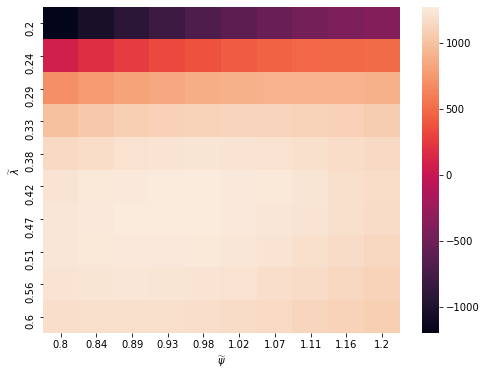

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame(
        scores,
        index=pd.Index(np.round(lambds, 2), name=r"$\widetilde{\lambda}$"),
        columns=pd.Index(np.round(psis, 2), name=r"$\widetilde{\psi}$"),
    )
)
plt.show()

In [8]:
i_max = np.argmax(scores) // scores.shape[0]
j_max = np.argmax(scores[i_max, :])

lambd_max, psi_max = lambds[i_max], psis[j_max]
print("lambd_max=%.2f , psi_max=%.2f" % (lambd_max, psi_max))

lambd_max=0.47 , psi_max=0.93


We find that $\widetilde{\lambda}=0.47, \widetilde{\psi}=0.93$

## Training

The agent is an actor critic architecture, both actor and critic networks are composed
of:
- an inital fully connected layer of size $16$ with a reLU activation,
- a hidden fully connected layer of size $16$ with a reLU activation and
- a linear output layer of size $1$.

The agent explores the environment with its current policy, an additive OU noise of
parameters $\theta=1, \sigma=1$, it puts the experiences in a replay buffer of size
$10^6$ and, we use Prioritized Experience Replay to sample a batch of size $512$ each
$50$ time steps when we run a learning iteration.

Before the training process starts, we run a pretraining phase and fill the replay
buffer with $1000$ experiences generated by exploring the environment with the initial
Actor network plus the additional OU noise.

In [9]:
# Agent parameters
MAX_STEPS = 5000
MEMORY_TYPE = "prioritized"
SLIDING = "oldest"
BATCH_SIZE = 2 ** 9
MAX_SIZE = int(1e6)

# Training parameters
TOTAL_EPISODES = 200  # set it to 501 for better convergence
TOTAL_STEPS = 1000
FREQ = 10
LEARN_FREQ = 50
TAU_ACTOR = 0.3
TAU_CRITIC = 0.1
LR_ACTOR = 1e-3
LR_CRITIC = 1e-2
WEIGHTS_DECAY_ACTOR = 0
WEIGHTS_DECAY_CRITIC = 0
FC1_UNITS_ACTOR = 16
FC2_UNITS_ACTOR = 16
FC1_UNITS_CRITIC = 16
FC2_UNITS_CRITIC = 16

100%|<bar/>| 199/200 [17:07<00:05,  5.06s/it]

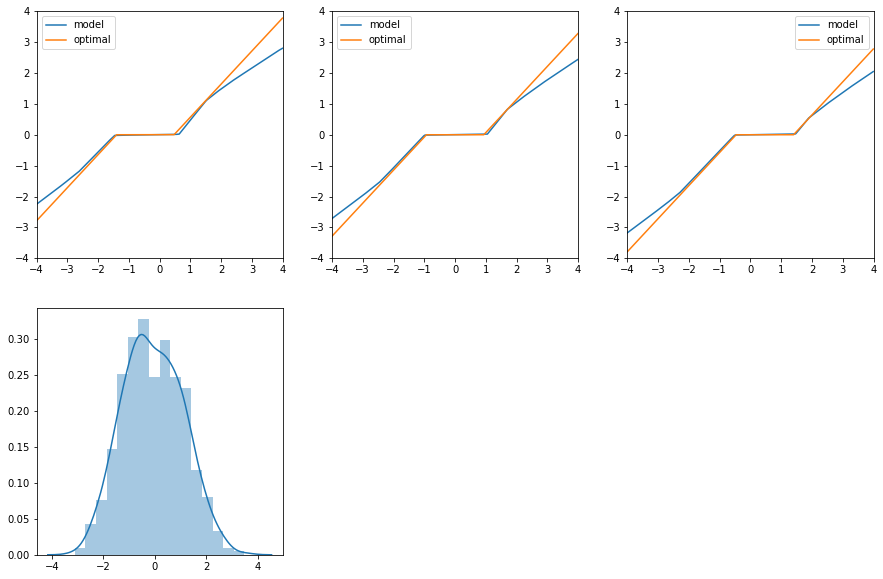


CPU times: user 17min 9s, sys: 43 s, total: 17min 52s
Wall time: 17min 8s


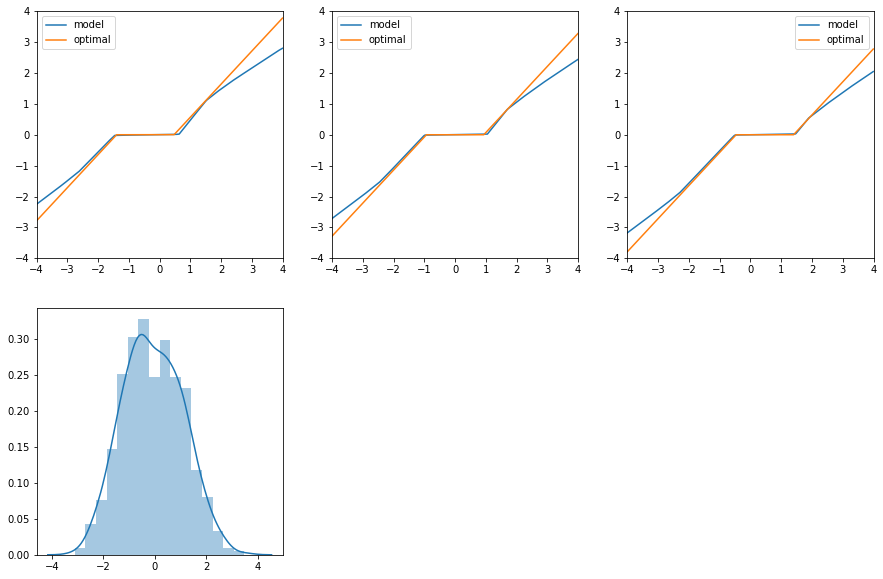

In [10]:
%%time
agent = Agent(
    max_size=MAX_SIZE,
    max_step=MAX_STEPS,
    memory_type=MEMORY_TYPE,
    sliding=SLIDING,
    batch_size=BATCH_SIZE,
)

path = "Experiment_linear_trading_cost_true_per/"
if not os.path.exists(path + "weights/"):
    os.makedirs(path + "weights/")

agent.train(
    env=env,
    total_episodes=TOTAL_EPISODES,
    tau_actor=TAU_ACTOR,
    tau_critic=TAU_CRITIC,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    weight_decay_actor=WEIGHTS_DECAY_ACTOR,
    weight_decay_critic=WEIGHTS_DECAY_CRITIC,
    total_steps=TOTAL_STEPS,
    weights=path + "weights/",
    freq=FREQ,
    fc1_units_actor=FC1_UNITS_ACTOR,
    fc2_units_actor=FC2_UNITS_ACTOR,
    fc1_units_critic=FC1_UNITS_CRITIC,
    fc2_units_critic=FC2_UNITS_CRITIC,
    learn_freq=LEARN_FREQ,
    plots=True,
    lambd=lambd_max,
    psi=psi_max,
    tensordir=path + "runs/",
    mile=100,
    decay_rate=1e-6,
)

***Evaluation***

We evaluate our models and compare them with the approximate optimal solution on $10$
new test episodes.

In [11]:
path_weights = path + "weights/"
scores, scores_episodes, scores_cumsum, pnls, positions = test_models(
    path_weights, env, n_episodes=10, fc1_units=16, fc2_units=16
)

In [12]:
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, lambd=lambd_max, psi=psi_max
)
scores[-1] = score
scores_episodes[-1] = score_episode

Given a predictor signal, we visualize both the positions taken by our agent and those
taken by the approximate optimal solution, we find that the positions evolve very
similarly .

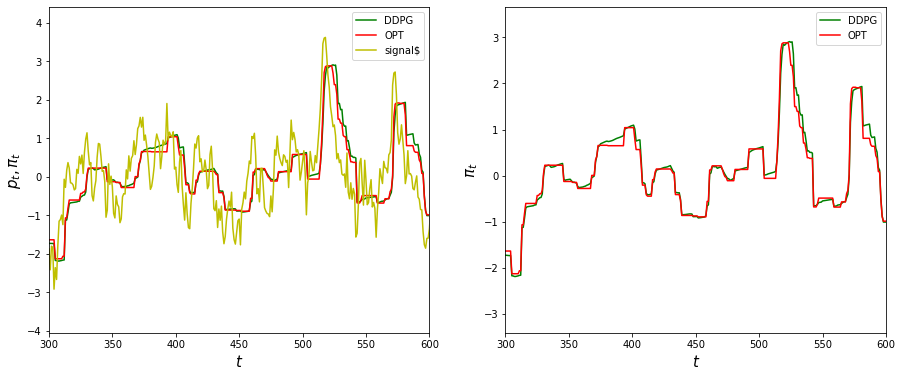

In [13]:
env.reset(random_state=730001)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(positions[110][730001], label="DDPG", color="g")
plt.plot(positions_opt[730001], label="OPT", color="r")
plt.plot(env.signal[1:], label="signal$", color="y")
plt.xlim(300, 600)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$p_t, \pi_t$", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(positions[110][730001], label="DDPG", color="g")
plt.plot(positions_opt[730001], label="OPT", color="r")
plt.xlim(300, 600)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\pi_t$", fontsize=15)
plt.legend()

plt.savefig("positions_penalty.png")
plt.show()

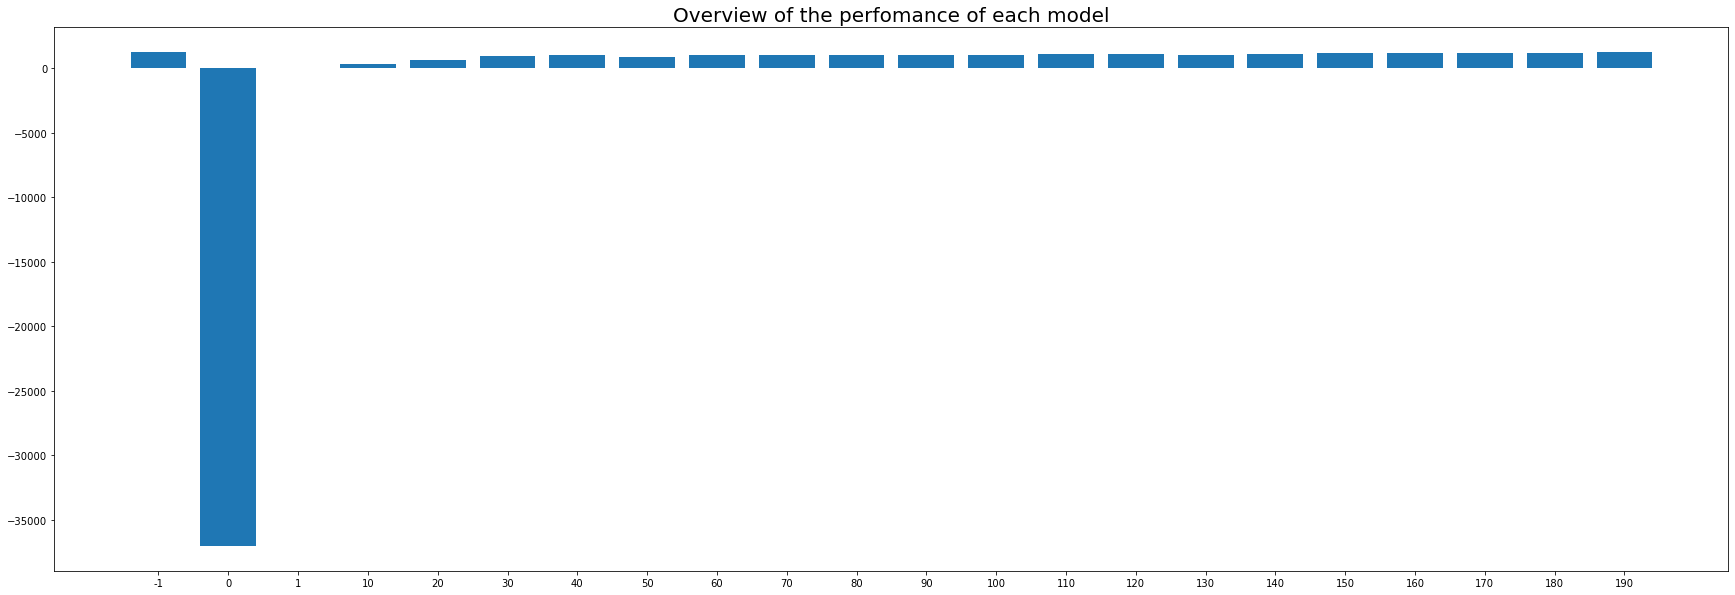

In [14]:
plot_bars(scores)

In [15]:
sorted_scores = sorted(scores.values(), reverse=True)
print("Optimal agent score   : %.2f" % sorted_scores[0])
print("Best DDPG agent score : %.2f" % sorted_scores[1])

Optimal agent score   : 1269.01
Best DDPG agent score : 1242.03


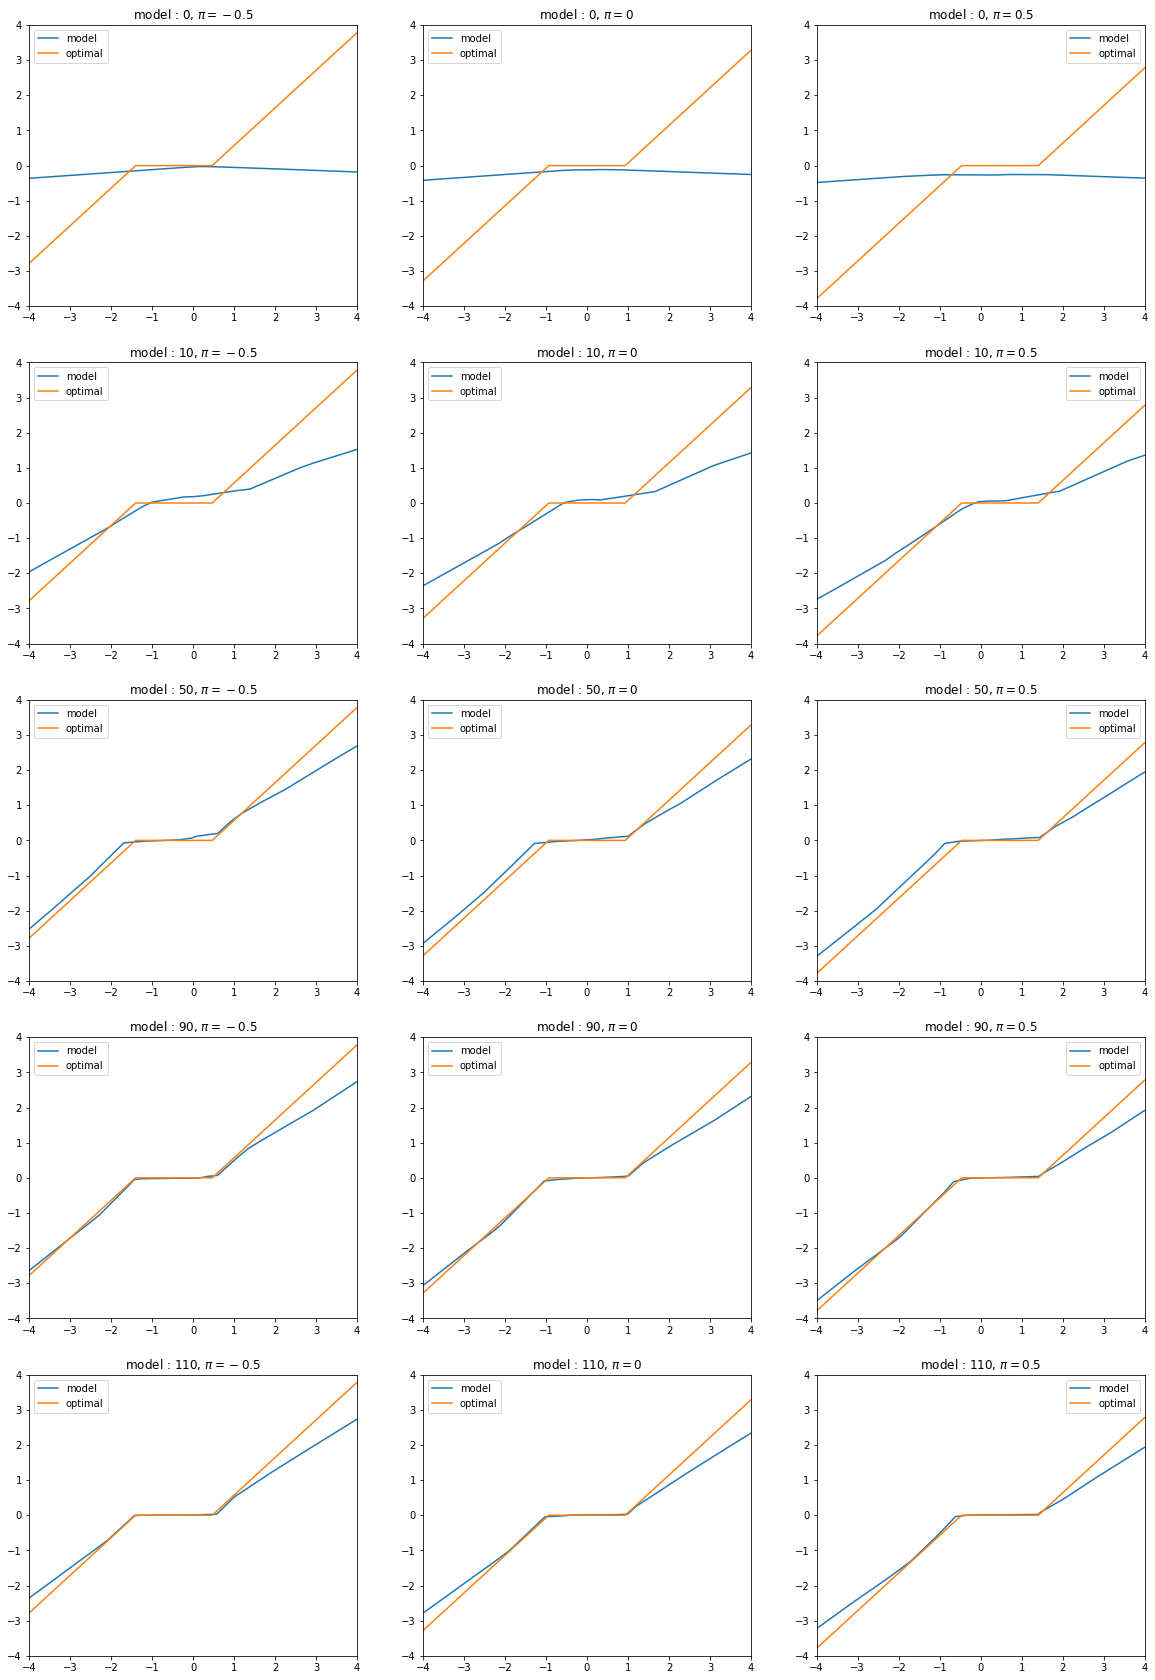

In [16]:
path_weights = path + "weights/"
models_keys = [0, 10, 50, 90, 110]
plot_function(
    path_weights,
    env,
    models_keys,
    low=-4,
    high=4,
    lambd=lambd_max,
    psi=psi_max,
    fc1_units=16,
    fc2_units=16,
)

# Linear trading costs with risk constraint

We can model the problem in two ways here:

We keep the reward: $r(\pi_t, p_t) = \pi_t p_t - \psi | \pi_t - \pi_{t-1}|;\hspace{2mm}
\lambda, \psi > 0$ and clip actions in the interval $\left[-M, M\right]$; this means
that an agent does not get penalized for making action $a$ taking its position $\pi$
beyond $M$, **i.e** $|\pi + a|>M$, since its next position $\pi'$ is s.t $|\pi'|=M$.

The second way is harder, it does not involve clipping the positions but rather
penalizes the agent for making actions taking its position outside the interval
$\left[-M, M \right]$. We can do this by adding a smooth penalty to the reward, and we
choose a $tanh$ barrier in the following way:
$$ r(\pi_t, p_t) = \pi_t p_t - \psi | \pi_t - \pi_{t-1}| - \beta\left( tanh\left[
\alpha\left( |\pi_t| - M - \gamma\right)\right] + 1\right);\hspace{2mm} \lambda, \psi,
\alpha, \beta, \gamma > 0 $$
This $tanh$ penalty is smooth and does not diverge for high $|\pi|$ values which makes
it useful in training stabilization compared to a constant penalty or an exponential
one.

***Optimal Solution***

for simplicity we will consider an approximate optimal solution which shape is
parameterized making this solution easily found by a simple grid-search.

$$
f\left(\pi_{t-1}, p_t \right) =
\begin{cases}
M - \pi_{t-1}; \hspace{2mm} p_t > \widetilde{q} \\
0 \hspace{13mm}; \hspace{2mm} |p_t| \le \widetilde{q} \\
-M - \pi_{t-1}; \hspace{2mm} p_t < -\widetilde{q}
\end{cases}
$$

Parameters $\widetilde{q}$ can be found with a gridSearch.

***Environment***

First, we will work with the first setting and only use an experience generator to get
some insight about how to properly explore and learn. Then we will work on both settings
in the exploration-learning scheme training.

We set our environment with the follwing parameters:
$$
\begin{cases}
\theta = 0.1 \\
\sigma = 0.1 \\
T = 5000 \\
M = 2 \\
\psi = 4
\end{cases}
$$

In [17]:
# Environment parameters

SIGMA = 0.1
THETA = 0.1
T = 5000
MAXPOS = 2
PSI = 4.0

In [18]:
env = Environment(
    sigma=SIGMA,
    theta=THETA,
    T=T,
    psi=PSI,
    cost="trade_l1",
    squared_risk=False,
    max_pos=MAXPOS,
    clip=True,
    penalty="tanh",
)

In [19]:
alpha, beta, gamma = 10, 10, MAXPOS / 4

In [20]:
def tanh_penalty(pi):
    return beta * (np.tanh(alpha * (abs(pi) - MAXPOS - gamma)) + 1)

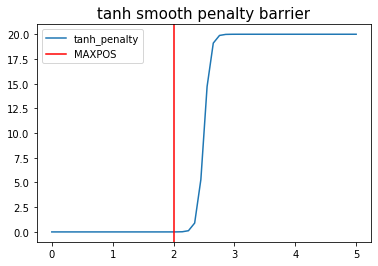

In [21]:
plt.plot(np.linspace(0, 5), tanh_penalty(np.linspace(0, 5)), label="tanh_penalty")
plt.axvline(MAXPOS, color="r", label="MAXPOS")
plt.title("tanh smooth penalty barrier", fontsize=15)
plt.legend()
plt.savefig("tanh_barrier.png")
plt.show()

In [22]:
# Agent parameters
MAX_STEPS = 5000
MEMORY_TYPE = "prioritized"
SLIDING = "oldest"
BATCH_SIZE = 2 ** 9
MAX_SIZE = int(1e6)

# Training parameters
TOTAL_EPISODES = 200  # set it to 501 for better convergence
TOTAL_STEPS = 10000
FREQ = 10
LEARN_FREQ = 50
TAU_ACTOR = 0.3
TAU_CRITIC = 0.1
LR_ACTOR = 1e-3
LR_CRITIC = 1e-2
WEIGHTS_DECAY_ACTOR = 0
WEIGHTS_DECAY_CRITIC = 0
FC1_UNITS_ACTOR = 16
FC2_UNITS_ACTOR = 16
FC1_UNITS_CRITIC = 16
FC2_UNITS_CRITIC = 16

100%|<bar/>| 199/200 [28:57<00:08,  8.77s/it]

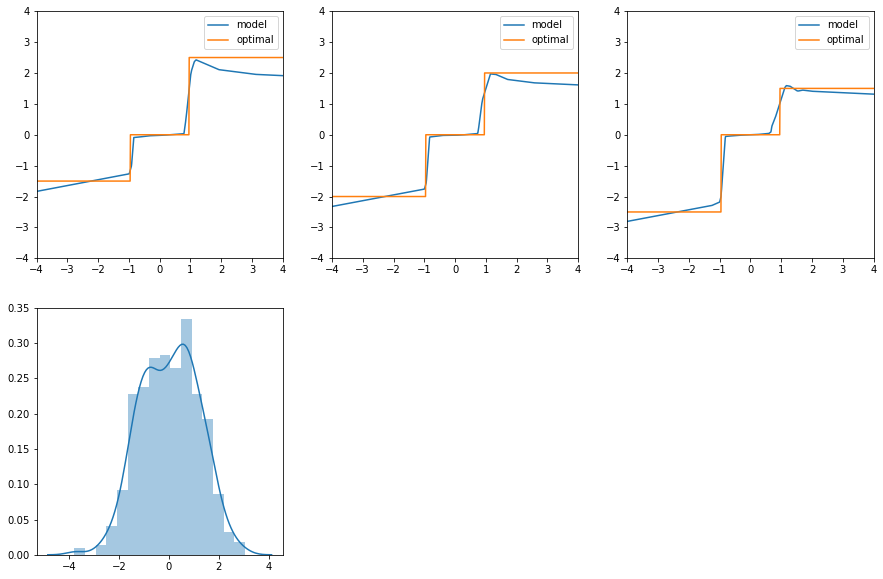


CPU times: user 29min 9s, sys: 31 s, total: 29min 40s
Wall time: 29min 10s


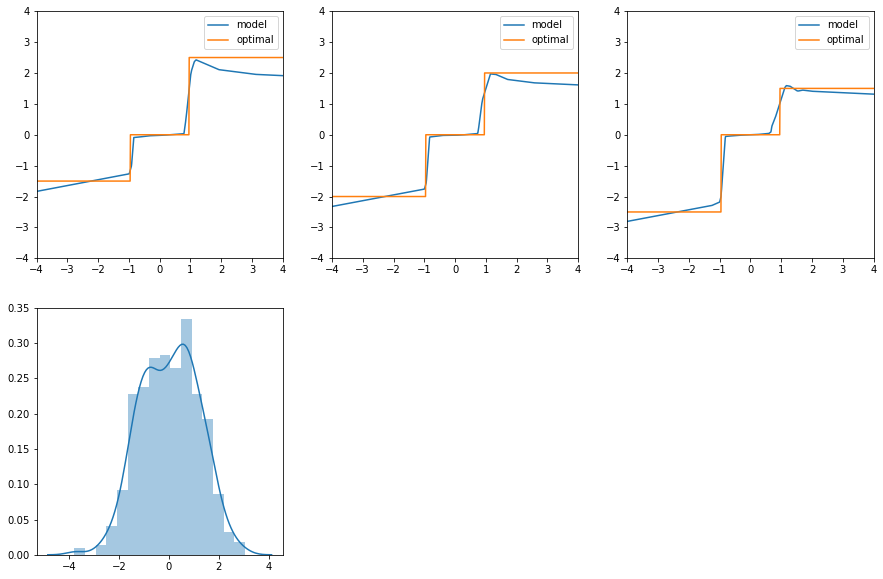

In [23]:
%%time
agent = Agent(
    max_size=MAX_SIZE,
    max_step=MAX_STEPS,
    memory_type=MEMORY_TYPE,
    sliding=SLIDING,
    batch_size=BATCH_SIZE,
    alpha=0.6,
    theta=0.1,
)

path = "Experiment_maxpos/"
if not os.path.exists(path + "weights/"):
    os.makedirs(path + "weights/")

agent.train(
    env=env,
    total_episodes=TOTAL_EPISODES,
    tau_actor=TAU_ACTOR,
    tau_critic=TAU_CRITIC,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    weight_decay_actor=WEIGHTS_DECAY_ACTOR,
    weight_decay_critic=WEIGHTS_DECAY_CRITIC,
    total_steps=TOTAL_STEPS,
    weights=path + "weights/",
    freq=FREQ,
    fc1_units_actor=FC1_UNITS_ACTOR,
    fc2_units_actor=FC2_UNITS_ACTOR,
    fc1_units_critic=FC1_UNITS_CRITIC,
    fc2_units_critic=FC2_UNITS_CRITIC,
    learn_freq=LEARN_FREQ,
    plots=True,
    thresh=0.95,
    tensordir=path + "runs/",
    mile=100,
    decay_rate=1e-5,
)


In [24]:
path_weights = path + "weights/"
scores, scores_episodes, scores_cumsum, pnls, positions = test_models(
    path_weights, env, n_episodes=10, fc1_units=16, fc2_units=16
)

In [25]:
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, thresh=0.95
)
scores[-1] = score
scores_episodes[-1] = score_episode

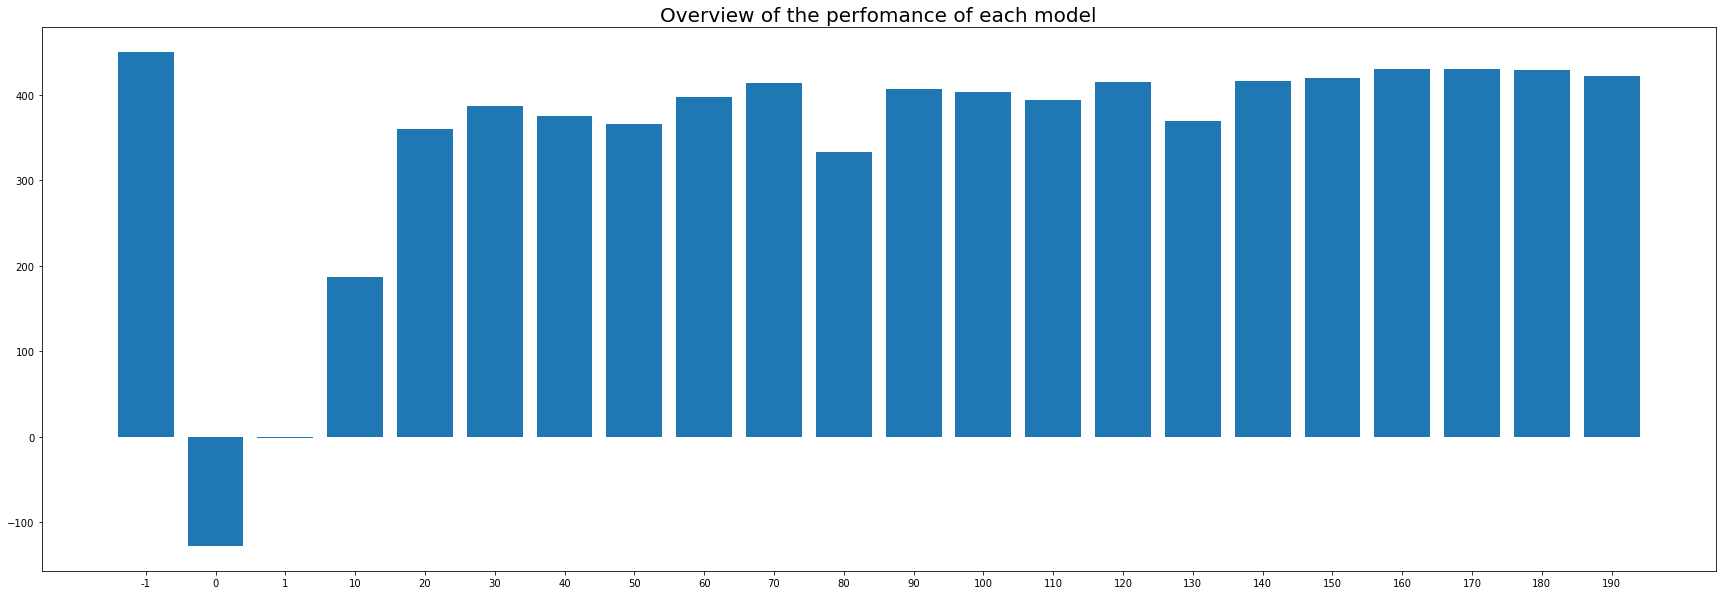

In [26]:
plot_bars(scores)

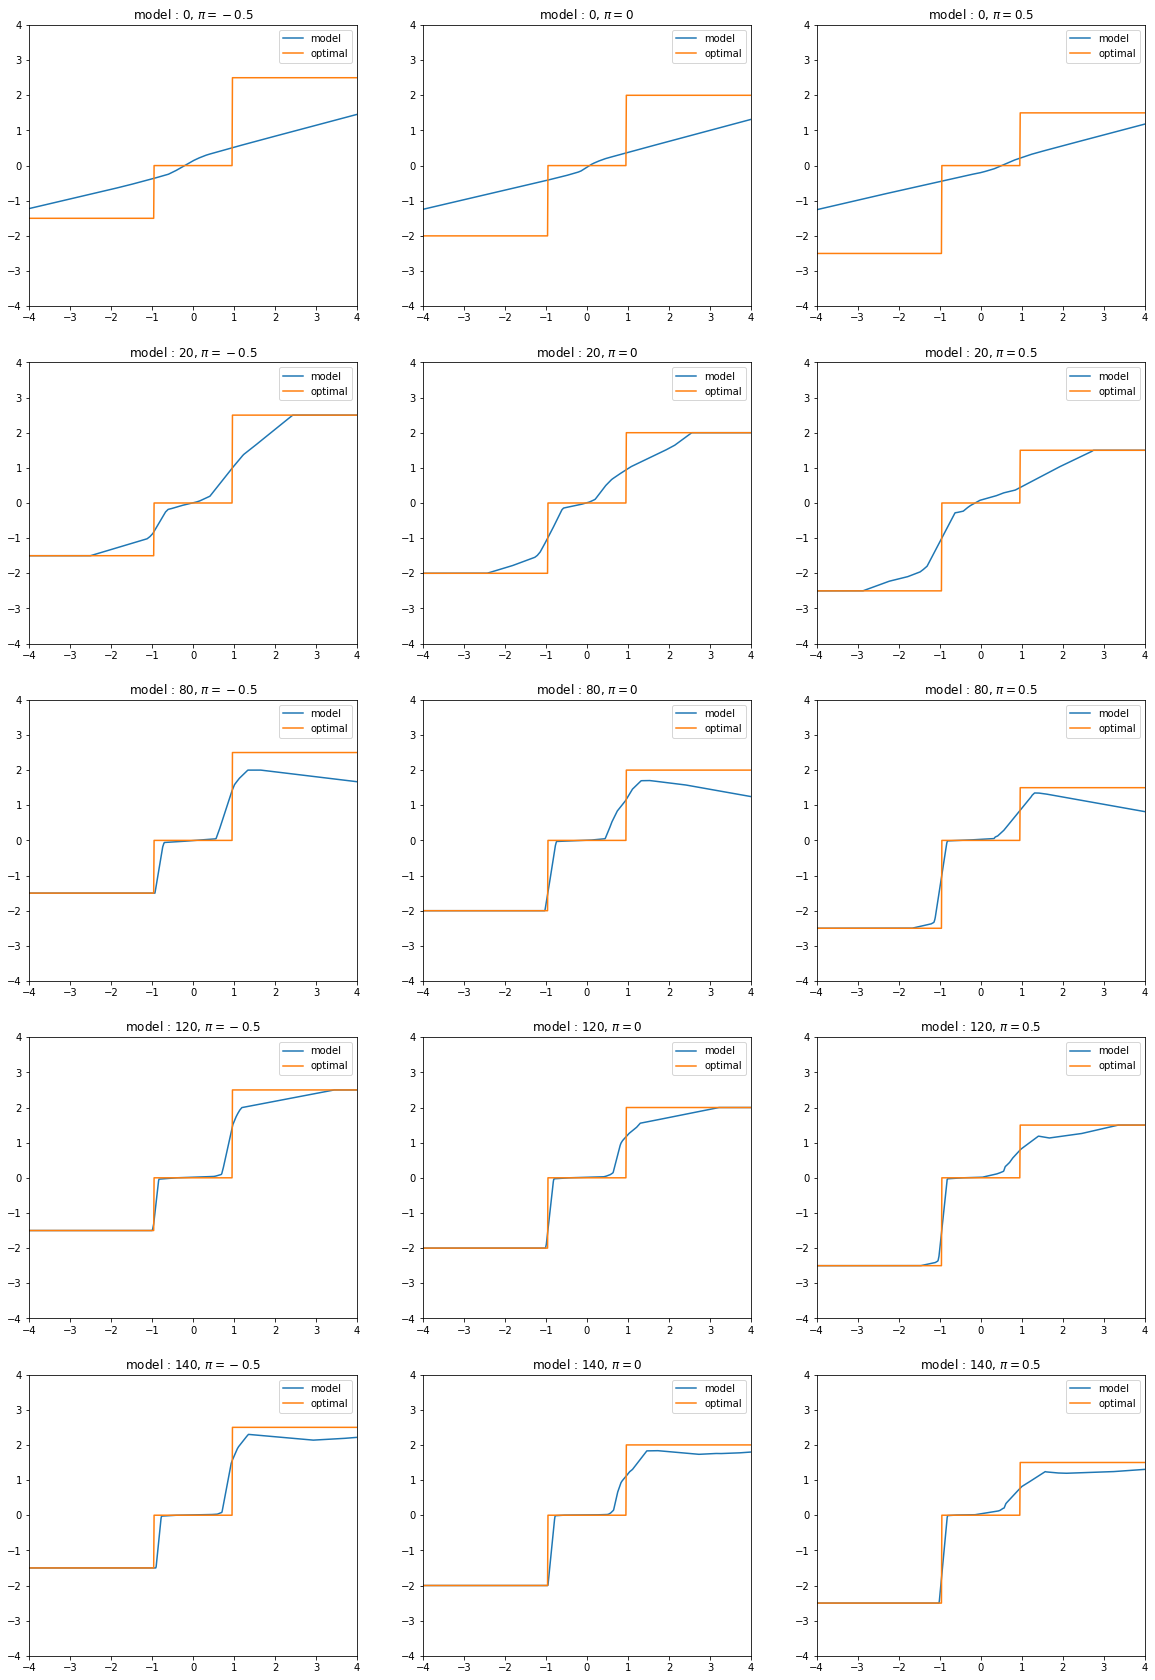

In [27]:
models_keys = [0, 20, 80, 120, 140]
plot_function(
    path_weights,
    env,
    models_keys,
    low=-4,
    high=4,
    lambd=0.3,
    fc1_units=16,
    fc2_units=16,
    thresh=0.95,
    clip=True,
)

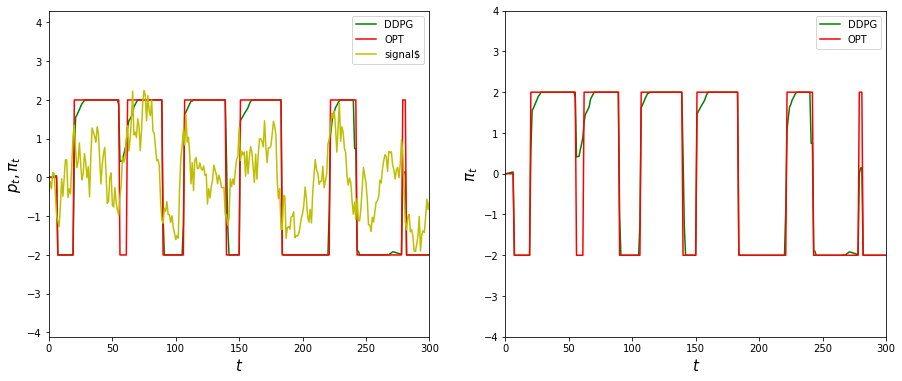

In [28]:
env.reset(random_state=989115)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(positions[140][989115], label="DDPG", color="g")
plt.plot(positions_opt[989115], label="OPT", color="r")
plt.plot(env.signal[1:], label="signal$", color="y")
plt.xlim(0, 300)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$p_t, \pi_t$", fontsize=15)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(positions[140][989115], label="DDPG", color="g")
plt.plot(positions_opt[989115], label="OPT", color="r")
plt.xlim(0, 300)
plt.ylim(-4, 4)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$\pi_t$", fontsize=15)
plt.legend()

plt.savefig("positions_constraint_per.png")
plt.show()

# Squared impact model

We consider the following cost model incorporating a squared impact cost:

$$
c(\pi_t, p_t) = -\pi_t p_t + \lambda \pi_t^2 + \phi \left( \pi_t -
\pi_{t-1}\right)^2;\hspace{2mm} \lambda, \phi > 0
$$

Given the predictor signal $\left( p_t\right)_t$ the optimal position $\pi_t$ at time
$t$ has the following form
$$
\pi_t = b\times EMA_a\left( p, t\right)
$$
Where $EMA_a\left( p, t\right)$ denotes the exponential moving average of preditor
signal $p$ at time $t$ with a decay of $0 < a \le 1$ and $b > 0$

We can now perform a grid-search over parameters $a$ and $b$

***Environment***

We set our environment with the follwing parameters:
$$
\begin{cases}
\theta = 0.1 \\
\sigma = 0.1 \\
T = 5000 \\
\lambda = 0.3 \\
\phi = 1
\end{cases}
$$

In [29]:
# Environment parameters

SIGMA = 0.1
THETA = 0.1
T = 5000
LAMBD = 0.3
PSI = 1

In [30]:
env = Environment(
    sigma=SIGMA,
    theta=THETA,
    T=T,
    lambd=LAMBD,
    psi=PSI,
    cost="trade_l2",
    scale_reward=10,
)

In [31]:
# Agent parameters
MAX_STEPS = 5000
MEMORY_TYPE = "prioritized"
SLIDING = "oldest"
BATCH_SIZE = 2 ** 9
MAX_SIZE = int(1e6)

# Training parameters
TOTAL_EPISODES = 200  # set it to 501 for better convergence
TOTAL_STEPS = 10000
FREQ = 10
LEARN_FREQ = 50
TAU_ACTOR = 0.3
TAU_CRITIC = 0.1
LR_ACTOR = 1e-3
LR_CRITIC = 1e-2
WEIGHTS_DECAY_ACTOR = 0
WEIGHTS_DECAY_CRITIC = 0
FC1_UNITS_ACTOR = 16
FC2_UNITS_ACTOR = 16
FC1_UNITS_CRITIC = 16
FC2_UNITS_CRITIC = 16

100%|<bar/>| 199/200 [18:39<00:05,  5.30s/it]

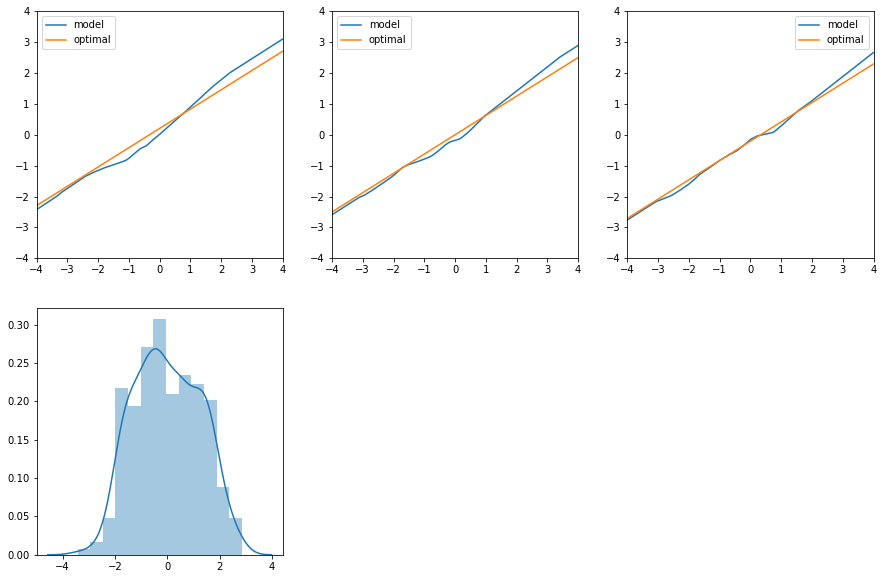


CPU times: user 18min 51s, sys: 40.1 s, total: 19min 31s
Wall time: 18min 47s


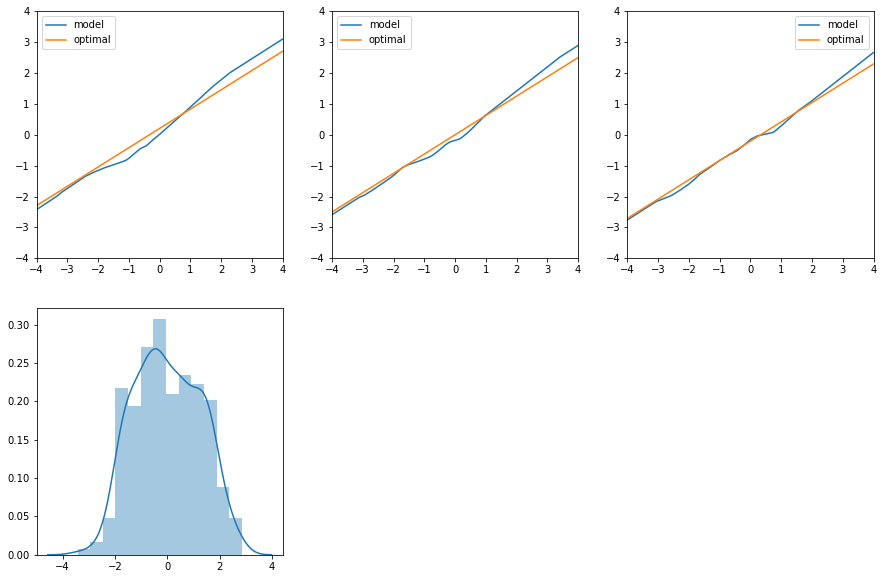

In [32]:
%%time
path = "Experiment_squared_cost/"
if not os.path.exists(path + "weights/"):
    os.makedirs(path + "weights/")

agent = Agent(
    max_size=MAX_SIZE,
    max_step=MAX_STEPS,
    memory_type=MEMORY_TYPE,
    sliding=SLIDING,
    batch_size=BATCH_SIZE,
    alpha=0.6,
    theta=0.1,
)
# agent = Agent(max_size = MAX_SIZE, max_step=MAX_STEPS, memory_type=MEMORY_TYPE,
# sliding=SLIDING, batch_size=BATCH_SIZE, alpha=0.6, point_max=2, n_points=5)
agent.train(
    env=env,
    total_episodes=TOTAL_EPISODES,
    tau_actor=TAU_ACTOR,
    tau_critic=TAU_CRITIC,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    weight_decay_actor=WEIGHTS_DECAY_ACTOR,
    weight_decay_critic=WEIGHTS_DECAY_CRITIC,
    total_steps=TOTAL_STEPS,
    weights=path + "weights/",
    freq=FREQ,
    fc1_units_actor=FC1_UNITS_ACTOR,
    fc2_units_actor=FC2_UNITS_ACTOR,
    fc1_units_critic=FC1_UNITS_CRITIC,
    fc2_units_critic=FC2_UNITS_CRITIC,
    learn_freq=LEARN_FREQ,
    plots=True,
    lambd=0.33,
    psi=0.47,
    tensordir=path + "runs/",
    mile=100,
    decay_rate=1e-5,
)

In [33]:
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, lambd=0.33, psi=0.47
)

In [34]:
path_weights = path + "weights/"
scores, scores_episodes, scores_cumsum, pnls, positions = test_models(
    path_weights, env, n_episodes=10, fc1_units=16, fc2_units=16
)

In [35]:
random_state = 1024
n_episodes = 10
rng = np.random.RandomState(random_state)
random_states = rng.randint(0, int(1e6), size=n_episodes)
score, score_episode, scores_cumsum_opt, pnls_opt, positions_opt = env.test_apply(
    total_episodes=n_episodes, random_states=random_states, thresh=0.95
)
scores[-1] = score
scores_episodes[-1] = score_episode

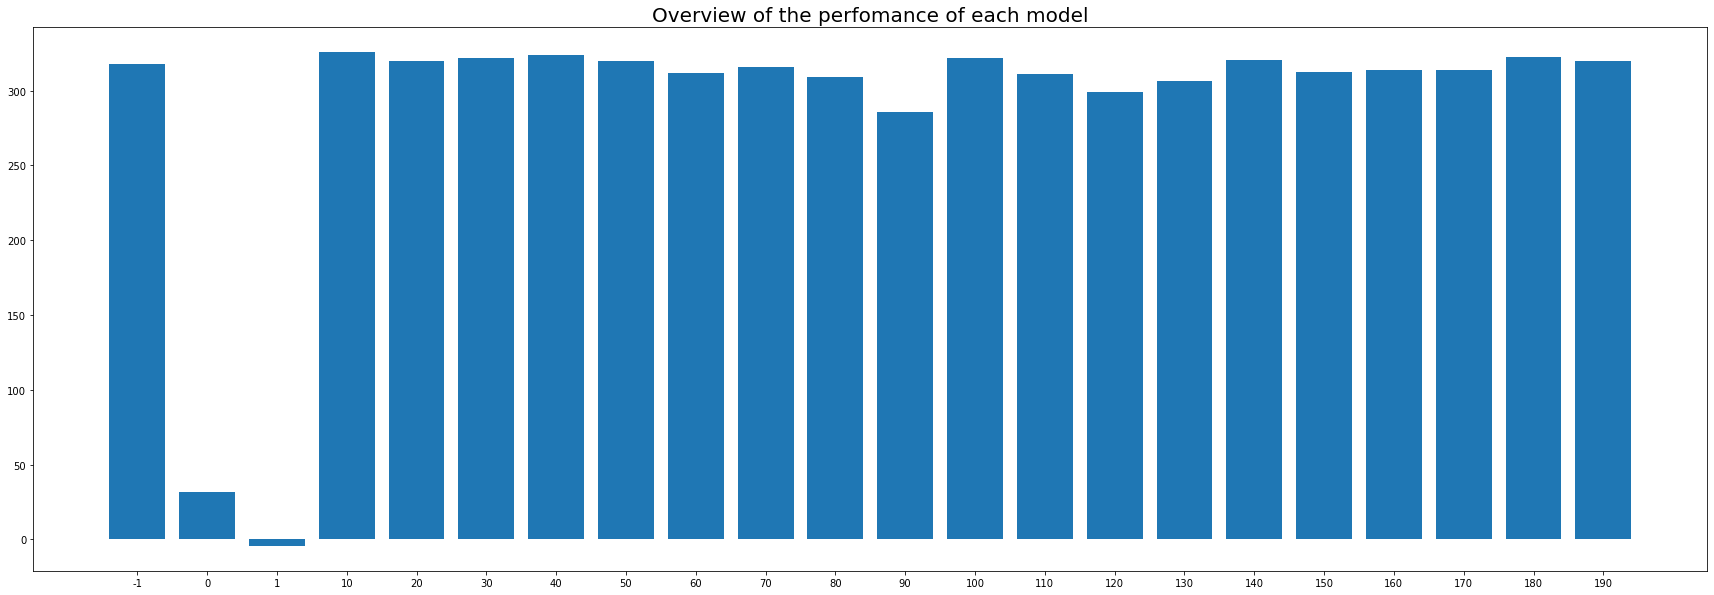

In [36]:
plot_bars(scores)

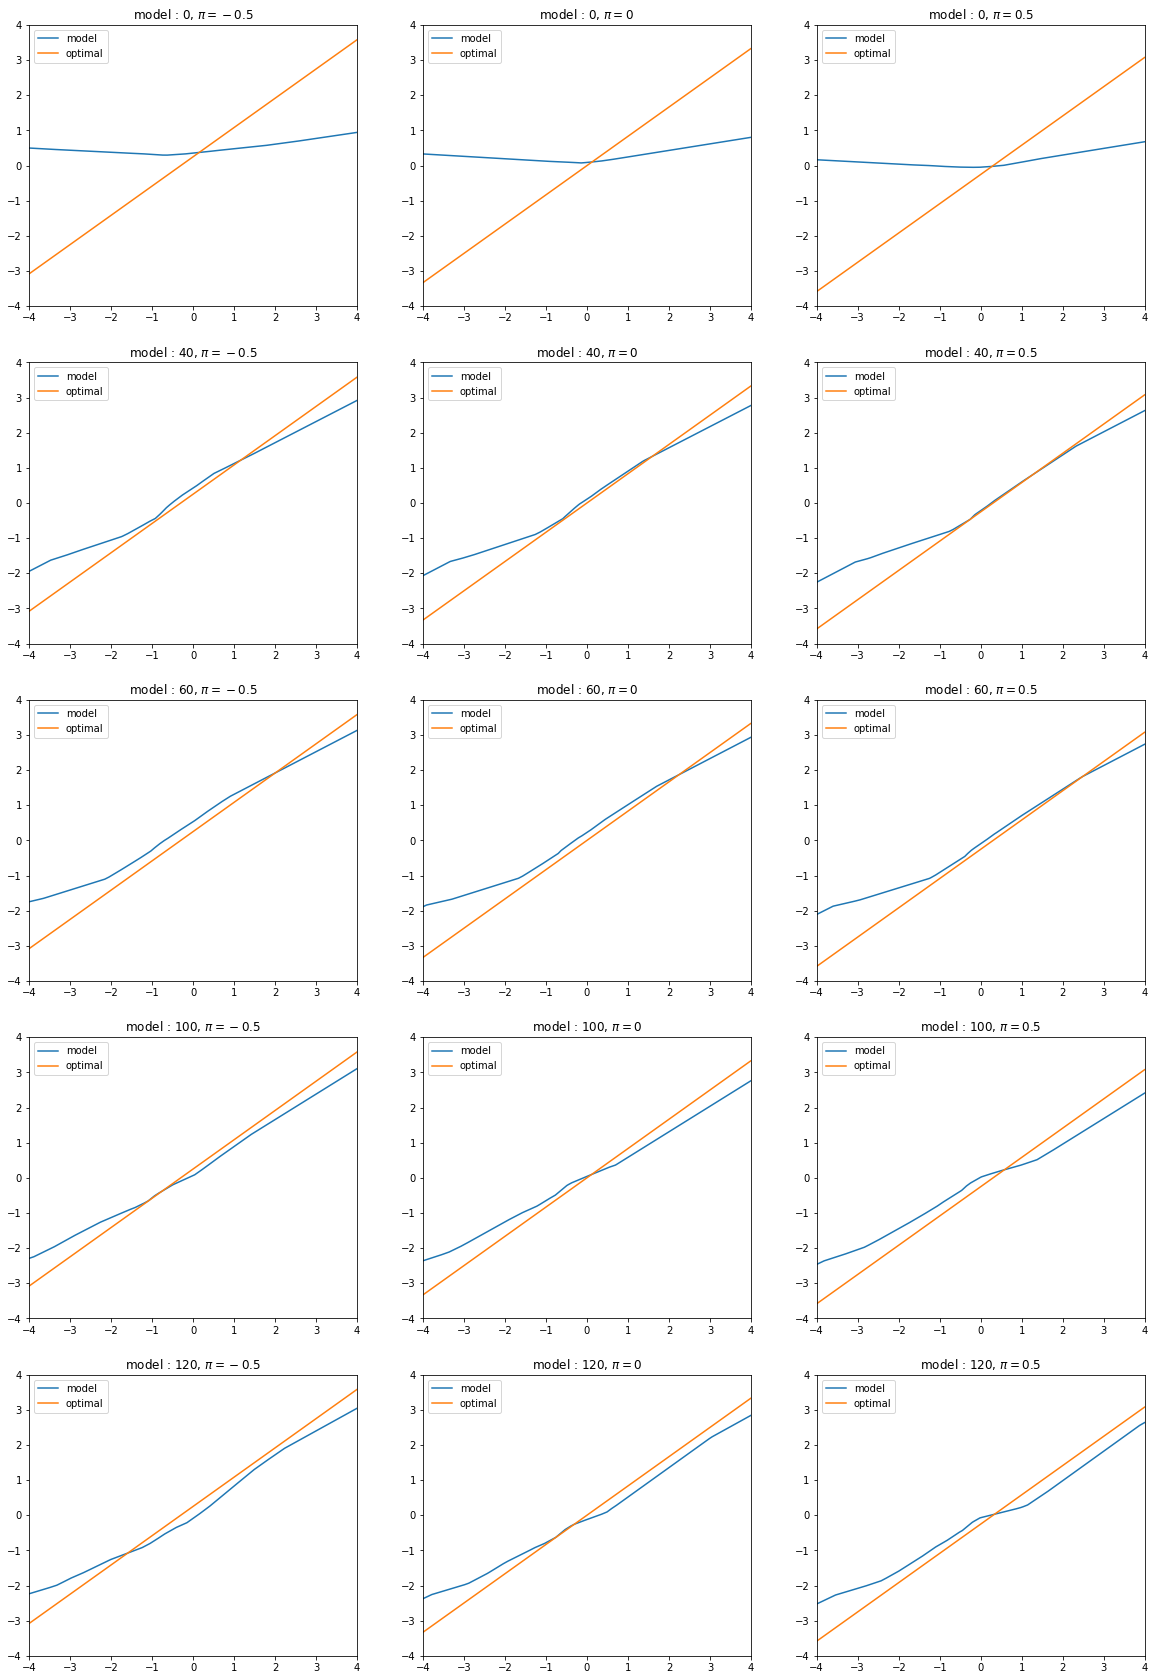

In [37]:
models_keys = [0, 40, 60, 100, 120]
plot_function(
    path_weights,
    env,
    models_keys,
    low=-4,
    high=4,
    lambd=0.3,
    fc1_units=16,
    fc2_units=16,
    thresh=0.95,
    clip=True,
)